# PFJAX: Particle Filtering with JAX

**Martin Lysy, University of Waterloo**

**November 11, 2021**

## Summary

The goal is to provide a fast implementation of a particle filter to estimate the marginal likelihood of a state-space model,
$$
\begin{aligned}
\mathcal{L}(\theta) & = p(y_{0:T} \mid \theta) \\
& = \int \prod_{t=0}^T p(y_t \mid x_t, \theta) \times \prod_{t=1}^T p(x_t \mid x_{t-1}, \theta) \times p(x_0 \mid \theta)\, d x_{0:T},   
\end{aligned}
$$
along with its gradient, $\nabla \mathcal{L}(\theta) = \frac{\partial}{\partial \theta} \mathcal{L}(\theta)$.  The [**JAX**](https://github.com/google/jax) library is used to efficiently compose jit and autodiff operations  in order to achieve this.

## API

For given $\theta$, the particle filter begins by running an importance sampler for $p(x_0 \mid y_0, \theta)$.  In order to do this, the user supplies a sampling proposal distribution,

$$
x_0 \sim q(x_0 \mid y_0, \theta),
$$

along with a function to calculate the importance log weights,

$$
w(x_0 \mid y_0, \theta) = \log p(y_0 \mid x_0, \theta) + \log p(x_0 \mid \theta) - \log q(x_0 \mid y_0, \theta).
$$

Since sampling from $q(x_0 \mid y_0, \theta)$ and computing $w(x_0 \mid y_0, \theta)$ involve many shared calculations, **pfjax** requires both to be performed in a single function:

```python
def pf_init(y_init, theta, key):
    # calculate x_init and logw
    return (x_init, logw)
```

Now suppose we have run the particle filter until step $t-1$.  In other words, the input is a weighted set of particles $((x_{t-1}^{(1)}, w_{t-1}^{(1)}), \ldots, (x_{t-1}^{(B)}, w_{t-1}^{(B)}))$ representing the distribution $p(x_{t-1} \mid y_{0:t-1}, \theta)$.  In order to get to a weighted set of particles representing $p(x_t \mid y_t, \theta)$, the user suppliles a sampling proposal distribution

$$
x_t \sim q(x_t \mid x_{t-1}, y_t, \theta)
$$

and a log-weight function

$$
w(x_t \mid x_{t-1}, y_t, \theta) = \log p(y_t \mid x_{t-1}, \theta) + \log p(x_t \mid x_{t-1}, \theta) - \log q(x_t \mid x_{t-1}, y_t, \theta).
$$

Again, these are supplied as a single function:

```python
def pf_step(x_prev, y_curr, theta, key):
    # claculate x_curr and logw
    return (x_curr, logw)
```

## Notation

### Functions

- `state_lpdf(x_curr, x_last, theta)`: Log-density of $p(x_t | x_{t-1}, \theta)$.
- `state_sample(x_last, theta)`: Sample from $p(x_t | x_{t-1}, \theta)$.
- `meas_lpdf(y_curr, x_curr, theta)`: Log-density of $p(y_t | x_t, \theta)$.
- `meas_sample(x_curr, theta)`: Sample from $p(y_t | x_t, \theta)$.

### Dimensions

- `n_obs`: Number of time points.
- `n_particle`: Number of particles.
- `n_state`: Tuple of state dimensions.
- `n_meas`: Tuple of measured dimensions.

## TODO

- [x] Test against true BM likelihood.

    Seem to get reasonable projection plots and a reasonable stochastic optimization.

- [x] Data should be $y_{0:T}$ instead of $y_{1:T}$.  This has been changed in some of the documentation but not all of it...

- [x] Add arbitrary prior specification $p(x_0 \mid \theta)$.  Should also be able to specify $x_0$ directly to calculate the marginal likelihood $\mathcal{L}(x_0, \theta) = p(y_{0:T} \mid x_0, \theta)$.

- [ ] Example where `n_state` and `n_meas` are not scalar.  This can be SDE with `n_res > 1`.

    **Update:** Implemented but not tested...

- [x] Interface for supplying new models to generic PF code.  Currently we have the following:

    ```python
    import pfjax as pf # generic code
    from my_model import MyModel # user-defined model

    # pf estimate of marginal loglikelihood
    def marginal_loglik(model, y_meas, theta, n_particles, key):
        out = pf.particle_filter(model, y_meas, theta, n_particles, key)
        return pf.particle_loglik(out["logw_particles"])
    
    # construct model object
    model = MyModel(dt=dt) # set dt as a data member
    marginal_loglik(model, y_meas, theta, n_particles, key)
    
    # jit + grad version
    marginal_loglik_jgrad = jax.jit(jax.grad(marginal_loglik, argnums=2), static_argnums=(0, 3))
    marginal_loglik_jgrad(model, y_meas, theta, n_particles, key)
    ```
    
    **WARNING:** The following code does not behave as "expected":
    
    ```python
    model.dt = 2 * dt # update value of dt
    marginal_loglik_jgrad(model, y_meas, theta, n_particles, key) # WARNING: uses the original dt...
    ```
    
    In other words, JAX does not recompile `marginal_loglik_jgrad()` with the updated value of `model`, even though we've flagged it with `static_argnums`.
    
- [ ] Add arbitrary proposal distribution $q(x_t \mid x_{t-1}, \theta)$.  This should perhaps be done using:

    ```python
    step_sample(x_prev, t, theta)
    step_logw(x_curr, x_prev, t, theta)
    ```
    
    instead of e.g., `state_prop_lpdf()`, `state_targ_lpdf()` and `meas_lpdf()` which gets assembled internally for the user.  This is what was done in [**SMCTC**](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/johansen/smctc/).  But what are the right args to these functions?  Sort of depends if they know about the "global" `y_meas`.  I think the right compromise is:
    
    ```python
    step_sample(x_prev, y_curr, t, theta)
    step_logw(x_curr, x_prev, y_curr, t, theta)
    ```
    
    In other words, can use `y_curr` for an optimal filter, can support non-homogeneous state-space models via `t`, and anything more complicated will require globals.
    
- [x] Add proper unit tests.  But of what?  Seems like JAX and NumPy are so similar that checking code from one against the other will hardly be that helpful...

    So, decided to test for-loop vs `vmap`/`xmap`/`lax.scan` etc always using JAX.  Reasoning is that without these constructs, JAX is identical to NumPy except PRNGs.
    
    Also testing OOP vs globals interface and jit + grad.

- [ ] Add CPU parallelism support.

    **Update:** Have started on an `xmap` implementation for this.  Trick will be to divide the `n_particles` axis into a 2D axis, in which the first is between (CPU) devices and the second is within each device.

## Example: Brownian motion with drift

The model is
$$
\newcommand{\N}{\mathcal{N}}
\newcommand{\dt}{\Delta t}
\begin{aligned}
x_0 & \sim \pi(x_0) \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2).
\end{aligned}
$$

Therefore, `n_state` = `n_meas` = 1, and we have a constant $\dt$ through which we never need to take derivatives.  

Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.

### Simulate data

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

# module containing pfjax (for now)
import particle_filter as pf
# module containing implementation of BM model
import bm_model as bm
# utility for plotting
from proj_data import proj_data

# initial key for random numbers
key = random.PRNGKey(0)

# parameter values
mu = 5.
sigma = .2
tau = 1.
theta = np.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = bm.BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.meas_sim(bm_model, n_obs, x_init, theta, subkey)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

ModuleNotFoundError: No module named 'particle_filter'

### Particle filter: Speed test with jit

In [3]:
# particle filter specification
n_particles = 100

# timing without jit
key, subkey = random.split(key)
%timeit pf.particle_filter(bm_model, y_meas, theta, n_particles, subkey)

1.31 s ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# timing with jit
jax.jit(pf.particle_filter, static_argnums=(0,3))(bm_model, y_meas, theta, n_particles, subkey)
%timeit jax.jit(pf.particle_filter, static_argnums=(0,3))(bm_model, y_meas, theta, n_particles, subkey)

1.22 ms ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Test against exact likelihood

The exact likelihood is defined as $p(y_{1:T} \mid y_0, \theta)$ rather than $p(y_{0:T} \mid \theta)$.  The reason is that the latter expression requires one to integrate over $x_0 \sim \pi(x_0)$, which can only be done when $\pi(x_0)$ is a proper prior.  However, for our choice of $\pi(x_0) \propto 1$ this is not the case.  On the other hand, $p(y_{1:T} \mid y_0, \theta)$ only requires us to integrate over $p(x_0 \mid y_0, \theta)$, which only requires the posterior to be proper (which is always the case for valid Bayesian inference).

Conditioned on $x_0$ and $\theta$, the Brownian latent variables $x_{1:T}$ are multivariate normal with
$$
\newcommand{\cov}{\operatorname{cov}}
\begin{aligned}
%E[x_0 \mid \theta] & = y_0 & \var(x_0\\
E[x_t \mid x_0, \theta] & = x_0 + \mu t, \\
\cov(x_s, x_t \mid x_0, \theta) & = \sigma^2 \min(s, t).
\end{aligned}
$$
Conditioned on $x_{0:T}$ and $\theta$, the measurement variables $y_{1:T}$ are multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_{0:T}, \theta] & = x_{1:T}, \\
\cov(y_s, y_t \mid x_{0:T}, \theta) & = \tau^2 \delta_{st}.
\end{aligned}
$$
Therefore, the marginal distribution of $y_{1:T}$ is multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_0, \theta] & = x_0 + \mu t, \\
\cov(y_s, y_t \mid x_0, \theta) & = \sigma^2 \min(s, t) + \tau^2 \delta_{st}.
\end{aligned}
$$
For the given choice of prior, we have $x_0 \mid y_0 \sim \N(y_0, \tau^2)$ for the initial observation $y_0$.  Integrating over $x_0$, the marginal distribution of $y_{1:T}$ is MVN with
$$
\begin{aligned}
E[y_t \mid y_0, \theta] & = y_0 + \mu t, \\
\cov(y_s, y_t \mid y_0, \theta) & = \sigma^2 \min(s, t) + \tau^2(\delta_{st} + 1).
\end{aligned}
$$

In [2]:
@jax.jit
def bm_loglik(y_meas, dt, theta):
    """
    Exact loglikelihood of the BM model.
    """
    mu = theta[0]
    sigma2 = theta[1] * theta[1]
    tau2 = theta[2] * theta[2]
    n_obs = y_meas.shape[0]-1  # conditioning on y_0
    t_meas = jnp.arange(1, n_obs+1) * dt
    Sigma_y = sigma2 * jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas) + \
        tau2 * (jnp.ones((n_obs, n_obs)) + jnp.eye(n_obs))
    mu_y = y_meas[0] + mu * t_meas
    return jsp.stats.multivariate_normal.logpdf(jnp.squeeze(y_meas[1:]), mu_y, Sigma_y)


bm_loglik(y_meas, dt, np.array([5, 1.2, 0]))

DeviceArray(-444.57486, dtype=float32)

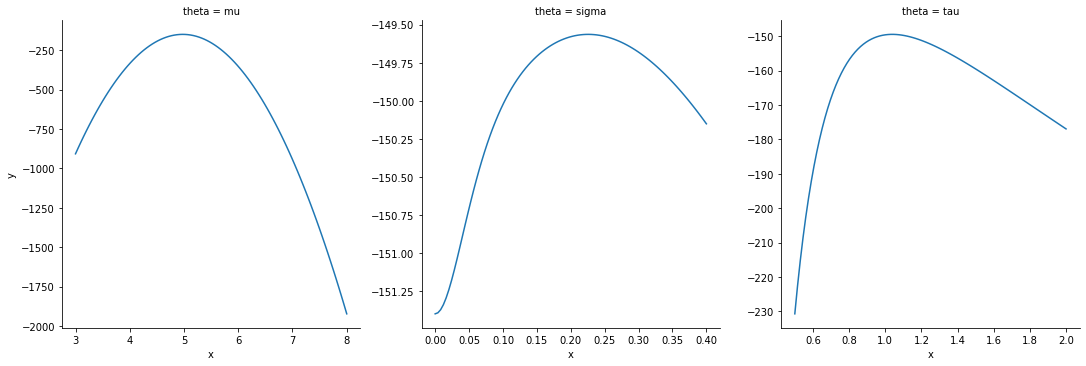

In [5]:
# plot exact likelihood
theta_lims = np.array([[3., 8.], [0., .4], [.5, 2]])
#theta_lims = np.array([[3., 8.], [.194, .195], [0, 10]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
plot_df = proj_data(lambda th: bm_loglik(y_meas, dt, th),
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    facet_kws=dict(sharex=False, sharey=False)
)

### Stochastic loglikelihood using particle filter



In [6]:
from particle_filter import stoch_opt, get_sum_lweights

In [7]:
stoch_opt(bm_model, jnp.array([1.,1.,1.]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=1000)

DeviceArray([4.986324  , 0.23830707, 1.0344669 ], dtype=float32)

## Scratch

Everything below is obsolete code that should not be expected to work as API evolves.

### Output script file with Jupyter highlighting

Just can't figure out how to resize output as desired...

In [2]:
# Output .py file with jupyter highlighting
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('particle_filter.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

### Tests with `pmap`

A few interesting threads:

- [Here's](https://github.com/google/jax/issues/5506) to tell XLA to use multiple CPUs.
- Not sure what happens if you set more devices than there are cores, so perhaps best to use `vmap` inside `pmap`.  However, could potentially do with [`xmap`](https://jax.readthedocs.io/en/latest/notebooks/xmap_tutorial.html) instead.  Note there an alternative way of setting the number of CPU devices from within Python, but may not actually dispatch to multiple cores...

In [1]:
import jax
jax.devices()

### Data members

In [15]:
from jax.tree_util import register_pytree_node


class World:
    def __init__(self, p, v):
        self.p = p
        self.v = v
        
    def set_v(self, v):
        self.v = v

register_pytree_node(World,
                    lambda x: ((x.p, x.v), None),
                    lambda _, tup: World(tup[0], tup[1]))


fun = jax.jit(lambda world, x: world.p + world.v + x, static_argnums=0)

world = World(jnp.array([1.]), jnp.array([2.]))
x = jnp.array([3.])

y1 = fun(world, x)
world.p = jnp.array([4.])
y2 = fun(world, x)
world.set_v(jnp.array([4.]))
y3 = fun(world, x)
world = World(jnp.array([1.]), jnp.array([4.]))
y4 = fun(world, x)

print("y1 = {}, y_2 = {}, y_3 = {}, y_4 = {}".format(y1, y2, y3, y4))

y1 = [6.], y_2 = [6.], y_3 = [6.], y_4 = [8.]


In [17]:
fun2 = jax.jit(lambda world, x: world["p"] + world["v"] + x, static_argnums=0)

world = {"p": jnp.array([1.]), "v": jnp.array([2.])}
x = jnp.array(3.)

y1 = fun2(world, x)
world["v"] = jnp.array([4.])
y2 = fun2(world, x)
world = {"p": jnp.array([1.]), "v": jnp.array([4.])}
y3 = fun2(world, x)

print("y1 = {}, y_2 = {}, y_3 = {}".format(y1, y2, y3))

ValueError: Non-hashable static arguments are not supported. An error occured during a call to '<lambda>' while trying to hash an object of type <class 'dict'>, {'p': DeviceArray([1.], dtype=float64), 'v': DeviceArray([2.], dtype=float64)}. The error was:
TypeError: unhashable type: 'dict'


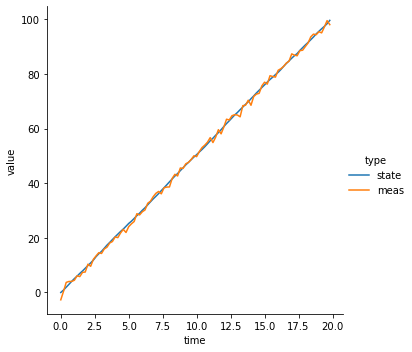

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from proj_data import proj_data

# Simulate some data
key = random.PRNGKey(10)

# parameter values
mu = 5.
sigma = .2
tau = 1.
theta = np.array([mu, sigma, tau])
# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
key, subkey = random.split(key)
y_meas, x_state = meas_sim(n_obs, x_init, theta, subkey)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

In [22]:
# now with particle filter
n_particles = 100
theta = jnp.array([mu, sigma, tau])
%timeit pf_out = particle_filter_scan(y_meas, theta, n_particles, key)

1.17 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# for tau = 0, MLE of mu and sigma are analytically available
mu_hat = jnp.mean(jnp.diff(jnp.squeeze(y_meas)))/dt
sigma_hat = jnp.sqrt(jnp.mean((jnp.diff(jnp.squeeze(y_meas)) - mu*dt)**2)/dt)
sigma_hat2 = jnp.std(jnp.diff(jnp.squeeze(y_meas))) / np.sqrt(dt)
print("mu_hat = ", mu_hat)
print("sigma_hat = ", sigma_hat)
print("sigma_hat2 = ", sigma_hat2)
print("theta = ", theta)
# bm_loglik(y_meas, dt, np.array([mu, sigma, tau]))

In [ ]:
plot_df = (pd.DataFrame(np.concatenate((plot_data[0], plot_data[1])).T,
                        columns=[a+b for b in map(str, ["_x", "_y"]) for a in theta_names])
           .melt()
           )
plot_df[["theta", "axis"]] = plot_df["variable"].str.split("_", 1, expand=True)
plot_df = plot_df[["axis", "theta", "value"]]
# plot_df
plot_df.pivot(columns="axis", values=["theta", "value"])
# df = pd.DataFrame({'foo': ['one', 'one', 'one', 'two', 'two',
#                           'two'],
#                   'bar': ['A', 'B', 'C', 'A', 'B', 'C'],
#                   'baz': [1, 2, 3, 4, 5, 6],
#                   'zoo': ['x', 'y', 'z', 'q', 'w', 't']})
# df
#df.pivot(index='foo', columns='bar', values='baz')

In [ ]:
pd.DataFrame(
    jnp.array([[4, 7, 10],
               [5, 8, 11],
               [6, 9, 12]]),
    #index=[1, 2, 3],
    columns=['a', 'b', 'c'])

In [ ]:
# check how smooth random.choice is

key = random.PRNGKey(2)


def fun(p):
    """
    Sample one draw from a Bernoulli with probability `p`.
    """
    return random.choice(key, a=jnp.arange(2), p=jnp.array([p, 1-p]))


# see how output varies as we keep the seed fixed but let p range between 0 and 1
n = 100
prob = jnp.linspace(0, 1, n)
x = jnp.zeros(n)
for i in range(n):
    x = x.at[i].set(fun(prob[i]))

# result: sampler is indeed smooth in p.
x